## Proses Instalasi

In [1]:
! pip install pandas==0.23.4
! pip install keras==2.3.1
! pip install termcolor==1.1.0
! pip install six==1.16.0
! pip install tensorflow==1.13.1
! pip install numpy==1.16.2
! pip install matplotlib==2.2.4
! pip install scikit-learn==0.24.2
! pip install h5py==2.10.0
! pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /private/var/folders/7q/ssgvc_153p3cclv0gvrlyk300000gn/T/pip-req-build-ewaf7tul
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /private/var/folders/7q/ssgvc_153p3cclv0gvrlyk300000gn/T/pip-req-build-ewaf7tul
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0


In [5]:
import warnings
warnings.filterwarnings("ignore")

## Memuat Library

In [6]:
import sys
import os
import json
import numpy as np

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import Adam
from keras.layers import Input, Dense
from keras.layers import GRU, LSTM, Bidirectional
from keras.layers import Embedding, TimeDistributed, Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras_contrib.layers.crf import CRF

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from operator import itemgetter

## Prapemrosesan Data

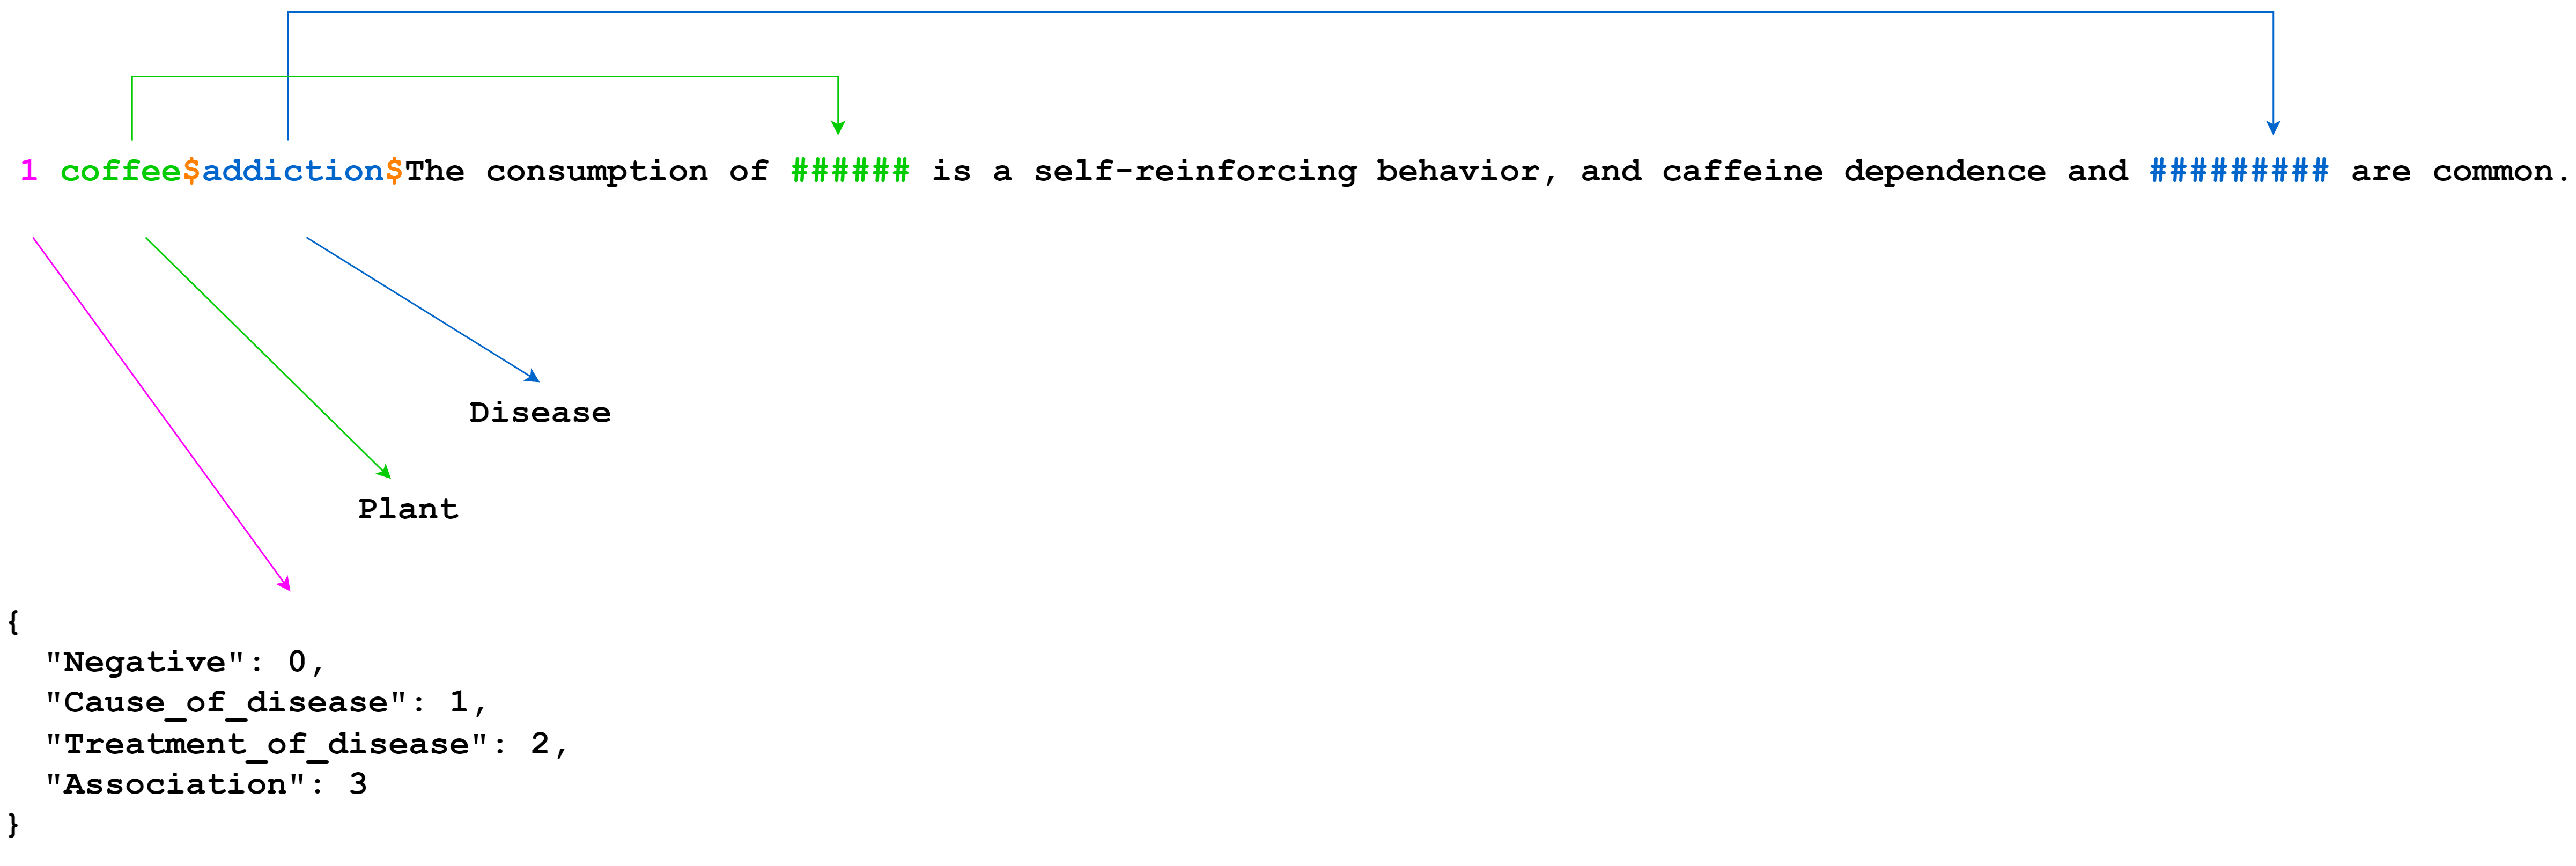

In [7]:
from IPython import display
display.Image("XtoT.png")

In [8]:
py_file_location = ""
sys.path.append(os.path.abspath(py_file_location))

In [9]:
from utils.load_data import get_train_test_pd
from utils.extract_feature import BertVector
from utils.att import Attention
from utils.crf import CRF

# Train

### Encoding Process

In [10]:
train_df, test_df = get_train_test_pd()
bert_model = BertVector(pooling_strategy="NONE", max_seq_len=512)
print('begin encoding')
f = lambda text: bert_model.encode([text])["encodes"][0]

train_df['x'] = train_df['text'].apply(f)
test_df['x'] = test_df['text'].apply(f)
print('end encoding')

I:PROCESS:[graph:opt: 49]:model config: /Users/slametriyanto/Documents/MyApp/Dissertation_Project/BILSTM_CRF_RE/multi_cased_L-12_H-768_A-12/bert_config.json
I:PROCESS:[graph:opt: 55]:build graph...



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



I:PROCESS:[graph:opt:132]:load parameters from checkpoint...
I:PROCESS:[graph:opt:134]:freeze...
I:PROCESS:[graph:opt:137]:optimize...
I:PROCESS:[graph:opt:148]:write graph to a tmp file: tmp_graph21


begin encoding
end encoding


### Training and Test Set

In [122]:
x_train = np.array([vec for vec in train_df['x']])
x_test = np.array([vec for vec in test_df['x']])
y_train = np.array([vec for vec in train_df['label']])
y_test = np.array([vec for vec in test_df['label']])

print('x_train: ', x_train.shape)
print('y_train: ', y_train.shape)
print('x_test: ', x_test.shape)
print('y_test: ', y_test.shape)

x_train:  (1177, 512, 768)
y_train:  (1177,)
x_test:  (130, 512, 768)
y_test:  (130,)


In [123]:
num_classes = 4 # {cause of disease, treatment of disease, association, negative}

In [124]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [231]:
#train_df

In [14]:
print("Size of training input data : ", x_train.shape)
print("Size of training output data : ", y_train.shape)
print("Size of testing input data : ", x_test.shape)
print("Size of testing output data : ", y_test.shape)

Size of training input data :  (1177, 512, 768)
Size of training output data :  (1177, 4)
Size of testing input data :  (130, 512, 768)
Size of testing output data :  (130, 4)


## Model Config

In [327]:
def build_model():
    inputs = Input(name="Input", shape=(512, 768, ))
    bilstm = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True, name="Long-Short-Term-Memory"), name="Bidirectional")(inputs)
    #attention = Attention(32, name="CRF-Attention")(bilstm)
    crf = CRF(num_classes, name="Conditional-Random-Field")(bilstm)
    dense = Dense(num_classes, activation='softmax', name="Output")(crf)
    model = Model(inputs, dense, name="Relation-Extraction-BiLSTM-CRF")

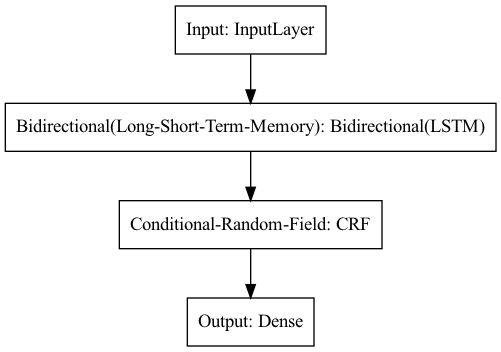

In [317]:
plot_model(model, to_file='model.png')

In [318]:
model.summary()

Model: "Relation-Extraction-BiLSTM-CRF"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 512, 768)          0         
_________________________________________________________________
Bidirectional (Bidirectional (None, 512, 256)          918528    
_________________________________________________________________
Conditional-Random-Field (CR (None, 256)               1540      
_________________________________________________________________
Output (Dense)               (None, 4)                 1028      
Total params: 921,096
Trainable params: 921,096
Non-trainable params: 0
_________________________________________________________________


In [321]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [322]:
keras_estimator = KerasClassifier(build_fn=build_model, verbose=1)

# define the randomized search parameters
param_grid = {
    'epochs': [1, 2, 3],
    'optimizer':['RMSprop', 'adam'],
    'spatial_dropout': [0.2, 0.3, 0.4],
    #'lstm_dropout': [0.20, 0.25, 0.30],
    'batch_size':[8, 16, 32],
}

In [323]:
kfold_splits = 10

random_search = RandomizedSearchCV(estimator=keras_estimator,  
                          n_jobs=-1, 
                          verbose=2,
                          refit=False,
                          scoring='f1',
                          cv=kfold_splits,
                          error_score='raise',
                          return_train_score=True,
                          param_distributions=param_grid)

tuning_results = random_search.fit(y_train, np.argmax(x_train, axis=1), ) 

# summarize results
print("Best: %f using %s" % (tuning_results.best_score_, tuning_results.best_params_))
means = tuning_results.cv_results_['mean_test_score']
stds = tuning_results.cv_results_['std_test_score']
params = tuning_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


exception calling callback for <Future at 0x7faf080ab4e0 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/Users/slametriyanto/opt/miniconda3/envs/relation/lib/python3.6/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/Users/slametriyanto/opt/miniconda3/envs/relation/lib/python3.6/site-packages/joblib/parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "/Users/slametriyanto/opt/miniconda3/envs/relation/lib/python3.6/site-packages/joblib/parallel.py", line 794, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/Users/slametriyanto/opt/miniconda3/envs/relation/lib/python3.6/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/slametriyanto/opt/miniconda3/envs/relation/lib/python3.6/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1)}

In [326]:
# Make grid input
batch_size  = [1644, 822, 548, 411, 328, 274, 234, 205, 182, 164]
epochs = [10, 50, 100, 150, 200, 250, 300]
learn_rate = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(epochs = epochs, batch_size = batch_size, learn_rate=learn_rate, momentum=momentum)

# Define model
def get_compiled_model_advanced(learn_rate=learn_rate, momentum=momentum):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')])
    # Compile model
    optimizer = SGD(lr=learn_rate, momentum=momentum, decay=0.5, nesterov=False)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_sgd = KerasClassifier(build_fn=get_compiled_model_advanced, verbose=0)

grid_sgd = GridSearchCV(estimator = model_sgd, param_grid = param_grid, n_jobs = 16, verbose=0)
sgd_fit = grid_sgd.fit(X, Y)

ValueError: Found input variables with inconsistent numbers of samples: [1177, 130]

## Model Visualization

# Model Process

In [264]:
model.summary()

Model: "sequential_172"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 1200, 24)          4224      
_________________________________________________________________
dense_63 (Dense)             (None, 1200, 2)           50        
Total params: 4,274
Trainable params: 4,274
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [60]:
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max')

# Fold0

In [61]:
# Save the latest val_acc best model file
filepath="output/e10-dr3-20bepoch-{epoch:02d}-val_los-{val_loss:.4f}-acc-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [62]:
history = model.fit(
    x_train, y_train, 
    validation_data=(x_test, y_test), 
    batch_size=8, 
    epochs=10, 
    callbacks=[checkpoint]) 
    #callbacks=[early_stopping, checkpoint])

Train on 1177 samples, validate on 130 samples
Epoch 1/10
1177/1177 [==============================] - 88s 75ms/step - loss: 1.0629 - accuracy: 0.5123 - val_loss: 1.0236 - val_accuracy: 0.4231

Epoch 00001: val_accuracy improved from -inf to 0.42308, saving model to output/fold0/8-0,5-10c/epoch-01-val_los-1.0236-acc-0.4231.hdf5
Epoch 2/10
1177/1177 [==============================] - 76s 65ms/step - loss: 0.9841 - accuracy: 0.5548 - val_loss: 0.9121 - val_accuracy: 0.5462

Epoch 00002: val_accuracy improved from 0.42308 to 0.54615, saving model to output/fold0/8-0,5-10c/epoch-02-val_los-0.9121-acc-0.5462.hdf5
Epoch 3/10
1177/1177 [==============================] - 77s 65ms/step - loss: 0.8527 - accuracy: 0.6253 - val_loss: 1.0483 - val_accuracy: 0.4923

Epoch 00003: val_accuracy did not improve from 0.54615
Epoch 4/10
1177/1177 [==============================] - 81s 69ms/step - loss: 0.7696 - accuracy: 0.6449 - val_loss: 0.9236 - val_accuracy: 0.5692

Epoch 00004: val_accuracy improved 

In [ ]:
print('The effect on the test set：', model.evaluate(x_test, y_test))

# Statistik Fold0

In [59]:
with open('input/rel_dict.json', 'r', encoding='utf-8') as f:
    label_id_dict = json.loads(f.read())

sorted_label_id_dict = sorted(label_id_dict.items(), key=itemgetter(1))
values = [_[0] for _ in sorted_label_id_dict]

In [60]:
model = load_model(
  "results/fold0/32/per-rel-08-0.5615.hdf5", 
  custom_objects={"CRF": CRF})

y_pred = model.predict(x_test, batch_size=32)

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=values))

                      precision    recall  f1-score   support

            Negative       0.52      0.55      0.53        58
    Cause_of_disease       0.89      0.44      0.59        18
Treatment_of_disease       0.56      0.65      0.60        51
         Association       0.00      0.00      0.00         3

            accuracy                           0.56       130
           macro avg       0.49      0.41      0.43       130
        weighted avg       0.57      0.56      0.56       130



## Epoch=100, drop=0,7

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


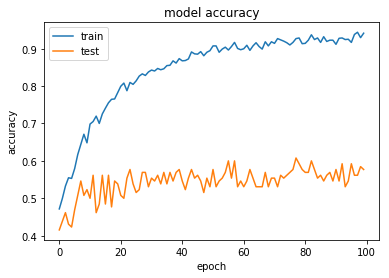

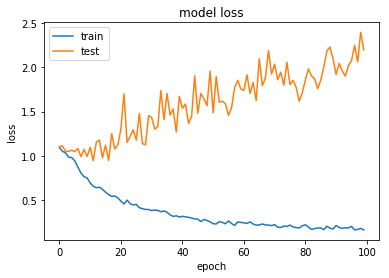

In [53]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Epoch=10, drop=0,5

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


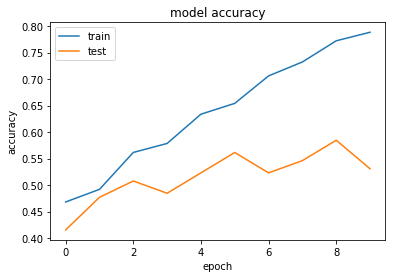

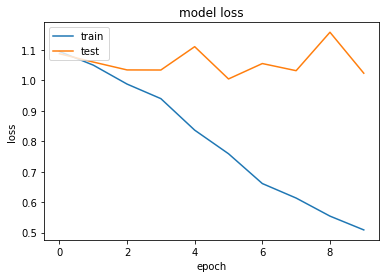

In [155]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [156]:
# Create pandas DataFrame
import pandas as pd

df_history = pd.DataFrame(history.history)
print(df_history)

   val_loss  val_accuracy      loss  accuracy
0  1.087789      0.415385  1.095250  0.468139
1  1.060509      0.476923  1.050404  0.491929
2  1.034586      0.507692  0.988090  0.561597
3  1.034305      0.484615  0.940251  0.578590
4  1.110977      0.523077  0.836724  0.633815
5  1.004941      0.561538  0.759213  0.654206
6  1.055547      0.523077  0.661292  0.706032
7  1.032089      0.546154  0.613602  0.732370
8  1.158385      0.584615  0.554282  0.772302
9  1.023778      0.530769  0.508952  0.788445


## Epoch=7, droup=0,7

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


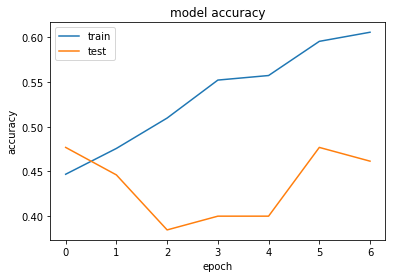

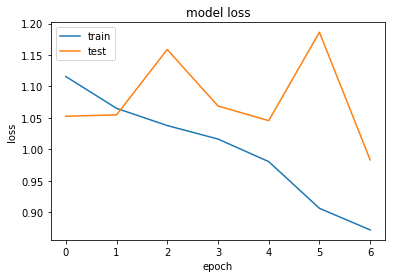

In [70]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Epoch=7, drop = 0,5

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


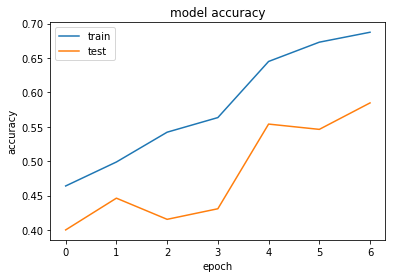

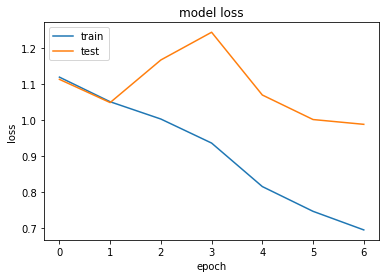

In [79]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Epoch=7, drop=5 B

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


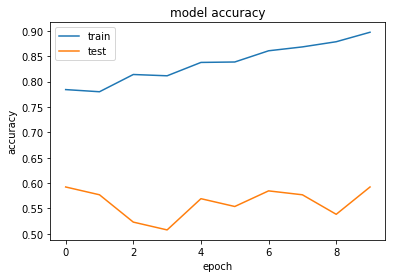

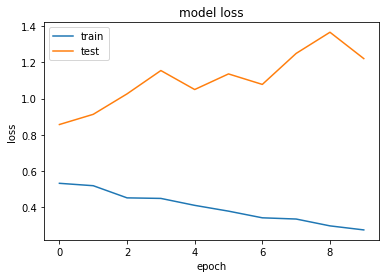

In [45]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [46]:
# Create pandas DataFrame
import pandas as pd

df_history = pd.DataFrame(history.history)
print(df_history)

   val_loss  val_accuracy      loss  accuracy
0  0.856616      0.592308  0.531846  0.784197
1  0.912936      0.576923  0.518558  0.779949
2  1.026036      0.523077  0.451405  0.813934
3  1.154843      0.507692  0.448351  0.811385
4  1.049964      0.569231  0.410036  0.837723
5  1.136230      0.553846  0.378052  0.838573
6  1.078219      0.584615  0.341204  0.860663
7  1.249440      0.576923  0.334447  0.868309
8  1.366471      0.538462  0.296644  0.878505
9  1.220882      0.592308  0.274310  0.897196


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


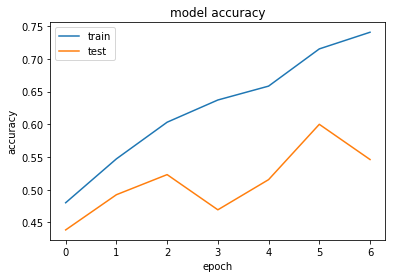

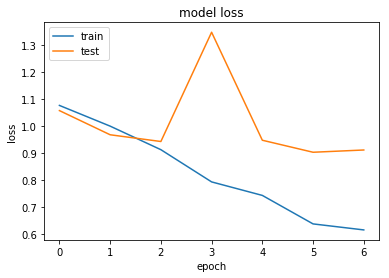

In [37]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [38]:
# Create pandas DataFrame
import pandas as pd

df_history = pd.DataFrame(history.history)
print(df_history)

   val_loss  val_accuracy      loss  accuracy
0  1.058212      0.438462  1.077385  0.480034
1  0.968571      0.492308  1.000603  0.547154
2  0.943597      0.523077  0.913288  0.603229
3  1.348697      0.469231  0.793844  0.637213
4  0.948308      0.515385  0.743768  0.658454
5  0.903763      0.600000  0.638100  0.715378
6  0.912141      0.546154  0.615823  0.740867


## Epoch=10, drop=0,5

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


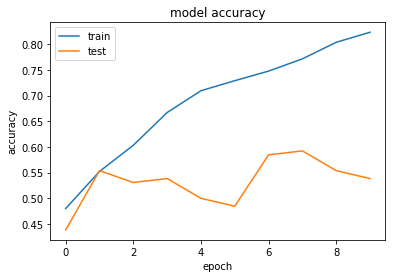

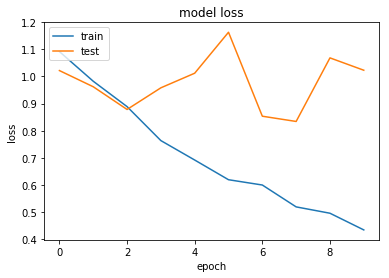

In [21]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
# Create pandas DataFrame
import pandas as pd

df_history = pd.DataFrame(history.history)
print(df_history)

   val_loss  val_accuracy      loss  accuracy
0  1.021735      0.438462  1.091680  0.480034
1  0.962101      0.553846  0.982423  0.552251
2  0.878438      0.530769  0.888931  0.603229
3  0.958184      0.538462  0.763703  0.666950
4  1.011980      0.500000  0.692120  0.709431
5  1.162928      0.484615  0.619533  0.728972
6  0.853548      0.584615  0.600054  0.747664
7  0.834210      0.592308  0.519454  0.771453
8  1.068476      0.553846  0.496068  0.803738
9  1.022958      0.538462  0.434606  0.823280


## Epoch=10, droup=0,5 B

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


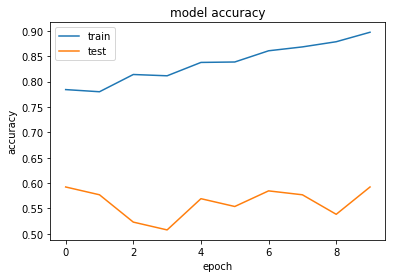

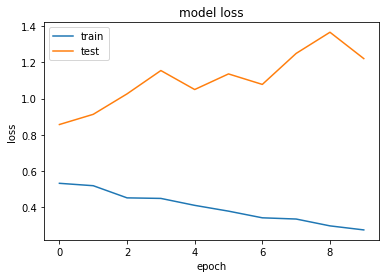

In [41]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
# Create pandas DataFrame
import pandas as pd

df_history = pd.DataFrame(history.history)
print(df_history)

   val_loss  val_accuracy      loss  accuracy
0  0.856616      0.592308  0.531846  0.784197
1  0.912936      0.576923  0.518558  0.779949
2  1.026036      0.523077  0.451405  0.813934
3  1.154843      0.507692  0.448351  0.811385
4  1.049964      0.569231  0.410036  0.837723
5  1.136230      0.553846  0.378052  0.838573
6  1.078219      0.584615  0.341204  0.860663
7  1.249440      0.576923  0.334447  0.868309
8  1.366471      0.538462  0.296644  0.878505
9  1.220882      0.592308  0.274310  0.897196


## Epoch=7, drop=0,3

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


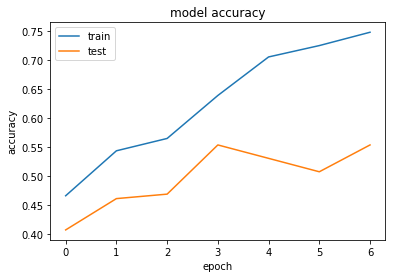

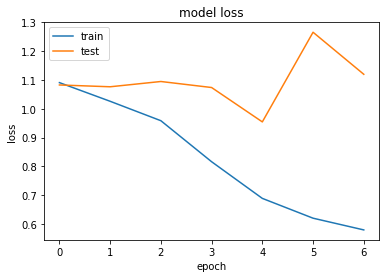

In [108]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
# Create pandas DataFrame
import pandas as pd

df_history = pd.DataFrame(history.history)
print(df_history)

   val_loss  val_accuracy      loss  accuracy
0  1.088009      0.446154  1.164640  0.445200
1  1.078266      0.446154  1.094084  0.446049
2  1.073179      0.446154  1.081840  0.446049
3  1.055719      0.438462  1.058771  0.446049
4  1.015413      0.430769  1.009954  0.485981
5  0.977621      0.484615  0.928075  0.603229
6  0.968279      0.492308  0.860698  0.658454
7  0.948018      0.523077  0.786863  0.700085
8  0.985507      0.476923  0.716721  0.712829
9  1.008083      0.500000  0.671402  0.751912


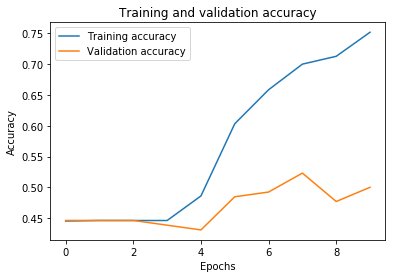

In [20]:
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Chart Loss and Accuracy

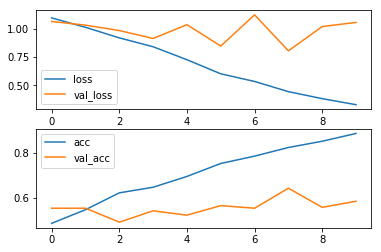

In [50]:
plt.subplot(2, 1, 1)
epochs = len(history.history['loss'])
plt.plot(range(epochs), history.history['loss'], label='loss')
plt.plot(range(epochs), history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(2, 1, 2)
epochs = len(history.history['accuracy'])
plt.plot(range(epochs), history.history['accuracy'], label='acc')
plt.plot(range(epochs), history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.savefig("output/loss_acc.png")

# Fold 1

In [20]:
# Save the latest val_acc best model file
filepath="results/fold1/16/per-rel-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [22]:
history = model.fit(
    x_train, y_train, 
    validation_data=(x_test, y_test), 
    batch_size=16, 
    epochs=50, 
    callbacks=[checkpoint]) 
    #callbacks=[early_stopping, checkpoint])

Train on 1046 samples, validate on 261 samples
Epoch 1/50
1046/1046 [==============================] - 6s 6ms/step - loss: 1.0668 - accuracy: 0.4799 - val_loss: 1.0294 - val_accuracy: 0.5479

Epoch 00001: val_accuracy did not improve from 0.56322
Epoch 2/50
1046/1046 [==============================] - 6s 6ms/step - loss: 1.0211 - accuracy: 0.5621 - val_loss: 1.0465 - val_accuracy: 0.4674

Epoch 00002: val_accuracy did not improve from 0.56322
Epoch 3/50
1046/1046 [==============================] - 6s 6ms/step - loss: 1.0009 - accuracy: 0.5516 - val_loss: 0.9537 - val_accuracy: 0.6054

Epoch 00003: val_accuracy improved from 0.56322 to 0.60536, saving model to results/fold1/16/per-rel-03-0.6054.hdf5
Epoch 4/50
1046/1046 [==============================] - 6s 6ms/step - loss: 0.9263 - accuracy: 0.6023 - val_loss: 0.9422 - val_accuracy: 0.5785

Epoch 00004: val_accuracy did not improve from 0.60536
Epoch 5/50
1046/1046 [==============================] - 6s 6ms/step - loss: 0.8706 - accurac

## Uji Fold1 - 16

In [23]:
with open('input/rel_dict.json', 'r', encoding='utf-8') as f:
    label_id_dict = json.loads(f.read())

sorted_label_id_dict = sorted(label_id_dict.items(), key=itemgetter(1))
values = [_[0] for _ in sorted_label_id_dict]

In [24]:
model = load_model(
  "results/fold1/16/per-rel-31-0.7510.hdf5", 
  custom_objects={"CRF": CRF})

y_pred = model.predict(x_test, batch_size=8)

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=values))

                      precision    recall  f1-score   support

            Negative       0.72      0.81      0.76       117
    Cause_of_disease       0.68      0.62      0.65        40
Treatment_of_disease       0.82      0.74      0.78        99
         Association       1.00      0.60      0.75         5

            accuracy                           0.75       261
           macro avg       0.80      0.69      0.73       261
        weighted avg       0.76      0.75      0.75       261



dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


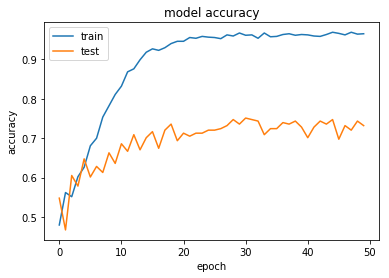

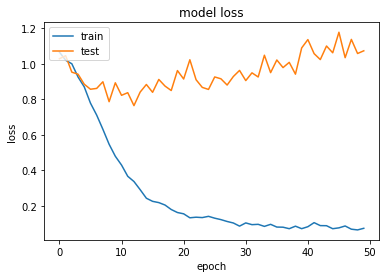

In [25]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
# Create pandas DataFrame
import pandas as pd

df_history = pd.DataFrame(history.history)
print(df_history)

    val_loss  val_accuracy      loss  accuracy
0   1.029444      0.547893  1.066839  0.479924
1   1.046466      0.467433  1.021094  0.562141
2   0.953686      0.605364  1.000900  0.551625
3   0.942213      0.578544  0.926321  0.602294
4   0.885674      0.647510  0.870631  0.626195
5   0.857558      0.601533  0.779220  0.680688
6   0.862233      0.628352  0.711777  0.699809
7   0.899592      0.613027  0.631737  0.753346
8   0.787330      0.662835  0.547627  0.782027
9   0.893879      0.636015  0.479991  0.810707
10  0.823287      0.685824  0.430479  0.831740
11  0.838121      0.666667  0.367162  0.868069
12  0.765220      0.708812  0.337649  0.875717
13  0.841616      0.670498  0.291691  0.898662
14  0.884310      0.701149  0.243531  0.917782
15  0.840224      0.716475  0.226074  0.926386
16  0.912739      0.674330  0.218940  0.922562
17  0.875387      0.720307  0.205222  0.929254
18  0.850328      0.735632  0.180070  0.939771
19  0.962635      0.693487  0.163062  0.945507
20  0.915195 

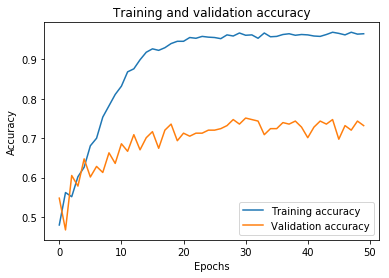

In [27]:
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Chart Loss & Accuracy

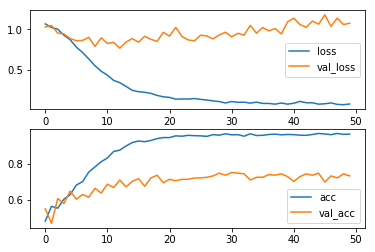

In [28]:
plt.subplot(2, 1, 1)
epochs = len(history.history['loss'])
plt.plot(range(epochs), history.history['loss'], label='loss')
plt.plot(range(epochs), history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(2, 1, 2)
epochs = len(history.history['accuracy'])
plt.plot(range(epochs), history.history['accuracy'], label='acc')
plt.plot(range(epochs), history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.savefig("output/loss_acc.png")

## Fold1 - 32

In [29]:
# Save the latest val_acc best model file
filepath="results/fold1/32/per-rel-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [31]:
history = model.fit(
    x_train, y_train, 
    validation_data=(x_test, y_test), 
    batch_size=32, 
    epochs=50, 
    callbacks=[checkpoint]) 
    #callbacks=[early_stopping, checkpoint])

Train on 1046 samples, validate on 261 samples
Epoch 1/50
1046/1046 [==============================] - 4s 4ms/step - loss: 0.0543 - accuracy: 0.9665 - val_loss: 1.1970 - val_accuracy: 0.7318

Epoch 00001: val_accuracy did not improve from 0.76245
Epoch 2/50
1046/1046 [==============================] - 4s 4ms/step - loss: 0.0557 - accuracy: 0.9675 - val_loss: 1.1070 - val_accuracy: 0.7471

Epoch 00002: val_accuracy did not improve from 0.76245
Epoch 3/50
1046/1046 [==============================] - 4s 4ms/step - loss: 0.0561 - accuracy: 0.9637 - val_loss: 1.1312 - val_accuracy: 0.7280

Epoch 00003: val_accuracy did not improve from 0.76245
Epoch 4/50
1046/1046 [==============================] - 4s 4ms/step - loss: 0.0527 - accuracy: 0.9723 - val_loss: 1.1674 - val_accuracy: 0.7356

Epoch 00004: val_accuracy did not improve from 0.76245
Epoch 5/50
1046/1046 [==============================] - 4s 4ms/step - loss: 0.0557 - accuracy: 0.9627 - val_loss: 1.1892 - val_accuracy: 0.7356

Epoch 00

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


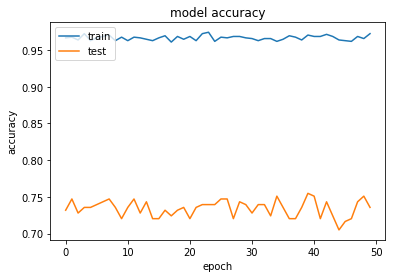

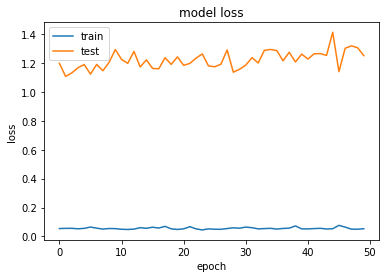

In [32]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
# Create pandas DataFrame
import pandas as pd

df_history = pd.DataFrame(history.history)
print(df_history)

    val_loss  val_accuracy      loss  accuracy
0   1.196967      0.731801  0.054308  0.966539
1   1.106979      0.747126  0.055665  0.967495
2   1.131209      0.727969  0.056062  0.963671
3   1.167365      0.735632  0.052717  0.972275
4   1.189225      0.735632  0.055734  0.962715
5   1.122731      0.739464  0.064858  0.966539
6   1.190083      0.743295  0.057072  0.968451
7   1.146172      0.747126  0.050660  0.970363
8   1.204178      0.735632  0.054761  0.962715
9   1.293000      0.720307  0.053836  0.967495
10  1.224247      0.735632  0.049449  0.962715
11  1.197263      0.747126  0.048147  0.967495
12  1.279871      0.727969  0.050329  0.966539
13  1.172315      0.743295  0.060565  0.964627
14  1.221429      0.720307  0.056071  0.962715
15  1.161763      0.720307  0.063508  0.966539
16  1.159864      0.731801  0.057831  0.969407
17  1.236308      0.724138  0.069621  0.960803
18  1.189988      0.731801  0.052415  0.968451
19  1.242085      0.735632  0.048271  0.964627
20  1.183263 

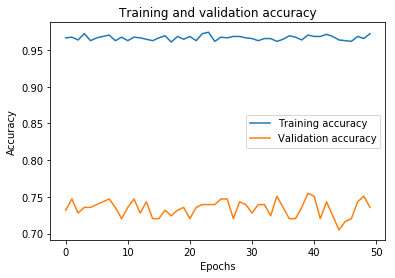

In [34]:
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Chart Loss & Accuracy

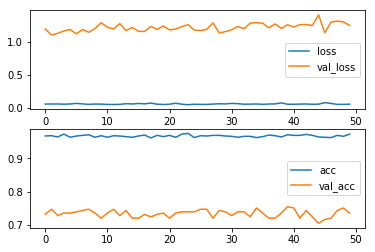

In [35]:
plt.subplot(2, 1, 1)
epochs = len(history.history['loss'])
plt.plot(range(epochs), history.history['loss'], label='loss')
plt.plot(range(epochs), history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(2, 1, 2)
epochs = len(history.history['accuracy'])
plt.plot(range(epochs), history.history['accuracy'], label='acc')
plt.plot(range(epochs), history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.savefig("output/loss_acc.png")

## Fold1 - 8

In [36]:
# Save the latest val_acc best model file
filepath="results/fold1/8/per-rel-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [37]:
history = model.fit(
    x_train, y_train, 
    validation_data=(x_test, y_test), 
    batch_size=8, 
    epochs=50, 
    callbacks=[checkpoint]) 
    #callbacks=[early_stopping, checkpoint])

Train on 1046 samples, validate on 261 samples
Epoch 1/50
1046/1046 [==============================] - 9s 9ms/step - loss: 0.2387 - accuracy: 0.9140 - val_loss: 1.0860 - val_accuracy: 0.6590

Epoch 00001: val_accuracy improved from -inf to 0.65900, saving model to results/fold1/8/per-rel-01-0.6590.hdf5
Epoch 2/50
1046/1046 [==============================] - 9s 9ms/step - loss: 0.2262 - accuracy: 0.9101 - val_loss: 1.0431 - val_accuracy: 0.6590

Epoch 00002: val_accuracy did not improve from 0.65900
Epoch 3/50
1046/1046 [==============================] - 9s 9ms/step - loss: 0.1278 - accuracy: 0.9465 - val_loss: 1.1133 - val_accuracy: 0.7203

Epoch 00003: val_accuracy improved from 0.65900 to 0.72031, saving model to results/fold1/8/per-rel-03-0.7203.hdf5
Epoch 4/50
1046/1046 [==============================] - 9s 9ms/step - loss: 0.0902 - accuracy: 0.9646 - val_loss: 1.1255 - val_accuracy: 0.7356

Epoch 00004: val_accuracy improved from 0.72031 to 0.73563, saving model to results/fold1/8

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


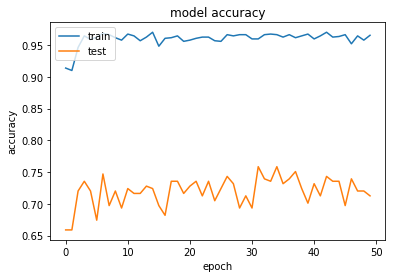

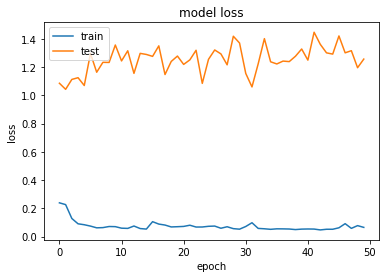

In [38]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [39]:
# Create pandas DataFrame
import pandas as pd

df_history = pd.DataFrame(history.history)
print(df_history)

    val_loss  val_accuracy      loss  accuracy
0   1.086049      0.659004  0.238735  0.913958
1   1.043117      0.659004  0.226157  0.910134
2   1.113259      0.720307  0.127778  0.946463
3   1.125480      0.735632  0.090152  0.964627
4   1.070064      0.720307  0.083516  0.958891
5   1.297169      0.674330  0.073888  0.962715
6   1.164172      0.747126  0.061641  0.968451
7   1.234382      0.697318  0.063161  0.966539
8   1.233575      0.720307  0.070979  0.961759
9   1.357137      0.693487  0.069972  0.957935
10  1.244438      0.724138  0.059116  0.967495
11  1.316220      0.716475  0.057587  0.964627
12  1.156182      0.716475  0.074422  0.956979
13  1.297864      0.727969  0.056489  0.962715
14  1.290223      0.724138  0.052732  0.970363
15  1.276627      0.697318  0.105218  0.948375
16  1.351060      0.681992  0.088151  0.960803
17  1.147906      0.735632  0.081253  0.961759
18  1.240597      0.735632  0.067883  0.964627
19  1.278732      0.716475  0.069559  0.956023
20  1.219665 

# Predict

In [51]:
! python model_predict.py

Using TensorFlow backend.
Instructions for updating:
Colocations handled automatically by placer.
2022-09-16 16:52:46.710520: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
Instructions for updating:
Use tf.cast instead.
tobacco$lung cancer$In conclusion, variation in ########### rates between populations may be due to: (1) differences in effective exposure to ####### smoke carcinogens; (2) differences in factors which modify the effect of ####### smoke, including differences in host susceptibility and metabolism of carcinogens, or (3) differences in exposure to other independent risk factors for ###########.
I:BERT_VEC:[graph:opt: 48]:model config: /Users/slametriyanto/Documents/MyApp/Dissertation_Project/BILSTM_CRF_RE/multi_cased_L-12_H-768_A-12/bert_config.json
I:BERT_VEC:[graph:opt: 54]:build graph...

For more information, please see:
  * https://github.com/tensorflow/community/blob/